In [2]:
try:
    import torch
except ModuleNotFoundError:
    !pip install torch torchvision
    import os
    import sys
    import torch

try:
    import cv2
except ModuleNotFoundError:
    !pip install opencv-python
    
if torch.__version__=='1.6.0+cu101' and sys.platform.startswith('linux'):
    !pip install pytorchvideo
else:
    need_pytorchvideo=False
    try:
        # Running notebook locally
        import pytorchvideo
    except ModuleNotFoundError:
        need_pytorchvideo=True
    if need_pytorchvideo:
        # Install from GitHub
        !pip install "git+https://github.com/facebookresearch/pytorchvideo.git"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/pytorchvideo.git to /tmp/pip-req-build-s1xj8y9f
  Running command git clone -q https://github.com/facebookresearch/pytorchvideo.git /tmp/pip-req-build-s1xj8y9f
     |████████████████████████████████| 50 kB 2.9 MB/s 
     |████████████████████████████████| 28.2 MB 80.2 MB/s 
     |████████████████████████████████| 42 kB 985 kB/s 
     |████████████████████████████████| 596 kB 45.3 MB/s 
  Created wheel for pytorchvideo: filename=pytorchvideo-0.1.5-py3-none-any.whl size=210715 sha256=f408386b70e5d8c6c4808427c33c0379f574198d7b99eddb82707d871faafa61
  Stored in directory: /tmp/pip-ephem-wheel-cache-fb706g_u/wheels/87/af/3d/0f80973f39ae2239c1ee9496b333ef4e90bf2d80d486b50eca
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220512-py3-none-any.whl size=61288 sha256=1982dcd4a4da98e9a4ae451bb3d8fbdcfaea6d28223c3ec8b259556a5a90266b
  Stored in di

In [4]:
!python -m pip install pyyaml==5.1
# Detectron2 has not released pre-built binaries for the latest pytorch (https://github.com/facebookresearch/detectron2/issues/4053)
# so we install from source instead. This takes a few minutes.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 4.7 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=eda5a7de3b1e2a5f3de451870c4e3cc13e627829d86784fdc82d5bf429df3d36
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-sqpxdm06
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-sqpxdm06
     |████████████████████████████████| 79 kB 3.7 MB/s 
     |████████████████████████████████| 151 kB 32

In [7]:
! git clone https://github.com/facebookresearch/pytorchvideo

Cloning into 'pytorchvideo'...
remote: Enumerating objects: 2382, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 2382 (delta 49), reused 62 (delta 21), pack-reused 2281
Receiving objects: 100% (2382/2382), 6.01 MiB | 24.03 MiB/s, done.
Resolving deltas: 100% (1321/1321), done.


In [9]:
%cd pytorchvideo

/content/pytorchvideo


In [10]:
! ls

CONTRIBUTING.md  INSTALL.md   pytorchvideo	    setup.py
dev		 LICENSE      pytorchvideo_trainer  tests
docs		 MANIFEST.in  README.md		    tutorials
hubconf.py	 projects     setup.cfg		    website


In [11]:
from functools import partial
import numpy as np

import cv2
import torch

import detectron2
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor

import pytorchvideo
from pytorchvideo.transforms.functional import (
    uniform_temporal_subsample,
    short_side_scale_with_boxes,
    clip_boxes_to_image,
)
from torchvision.transforms._functional_video import normalize
from pytorchvideo.data.ava import AvaLabeledVideoFramePaths
from pytorchvideo.models.hub import slow_r50_detection # Another option is slowfast_r50_detection

from tutorials.video_detection_example.visualization import VideoVisualizer

In [12]:
device = 'cuda' # or 'cpu'
video_model = slow_r50_detection(True) # Another option is slowfast_r50_detection
video_model = video_model.eval().to(device)

Downloading: "https://dl.fbaipublicfiles.com/pytorchvideo/model_zoo/ava/SLOW_4x16_R50_DETECTION.pyth" to /root/.cache/torch/hub/checkpoints/SLOW_4x16_R50_DETECTION.pyth


  0%|          | 0.00/243M [00:00<?, ?B/s]

In [13]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.55  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

# This method takes in an image and generates the bounding boxes for people in the image.
def get_person_bboxes(inp_img, predictor):
    predictions = predictor(inp_img.cpu().detach().numpy())['instances'].to('cpu')
    boxes = predictions.pred_boxes if predictions.has("pred_boxes") else None
    scores = predictions.scores if predictions.has("scores") else None
    classes = np.array(predictions.pred_classes.tolist() if predictions.has("pred_classes") else None)
    predicted_boxes = boxes[np.logical_and(classes==0, scores>0.75 )].tensor.cpu() # only person
    return predicted_boxes

model_final_280758.pkl: 167MB [00:05, 32.5MB/s]                           


In [14]:
def ava_inference_transform(
    clip, 
    boxes,
    num_frames = 4, #if using slowfast_r50_detection, change this to 32
    crop_size = 256, 
    data_mean = [0.45, 0.45, 0.45], 
    data_std = [0.225, 0.225, 0.225],
    slow_fast_alpha = None, #if using slowfast_r50_detection, change this to 4
):

    boxes = np.array(boxes)
    ori_boxes = boxes.copy()

    # Image [0, 255] -> [0, 1].
    clip = uniform_temporal_subsample(clip, num_frames)
    clip = clip.float()
    clip = clip / 255.0

    height, width = clip.shape[2], clip.shape[3]
    # The format of boxes is [x1, y1, x2, y2]. The input boxes are in the
    # range of [0, width] for x and [0,height] for y
    boxes = clip_boxes_to_image(boxes, height, width)

    # Resize short side to crop_size. Non-local and STRG uses 256.
    clip, boxes = short_side_scale_with_boxes(
        clip,
        size=crop_size,
        boxes=boxes,
    )
    
    # Normalize images by mean and std.
    clip = normalize(
        clip,
        np.array(data_mean, dtype=np.float32),
        np.array(data_std, dtype=np.float32),
    )
    
    boxes = clip_boxes_to_image(
        boxes, clip.shape[2],  clip.shape[3]
    )
    
    # Incase of slowfast, generate both pathways
    if slow_fast_alpha is not None:
        fast_pathway = clip
        # Perform temporal sampling from the fast pathway.
        slow_pathway = torch.index_select(
            clip,
            1,
            torch.linspace(
                0, clip.shape[1] - 1, clip.shape[1] // slow_fast_alpha
            ).long(),
        )
        clip = [slow_pathway, fast_pathway]
    
    return clip, torch.from_numpy(boxes), ori_boxes

In [15]:
!wget https://dl.fbaipublicfiles.com/pytorchvideo/data/class_names/ava_action_list.pbtxt

--2022-08-01 16:25:14--  https://dl.fbaipublicfiles.com/pytorchvideo/data/class_names/ava_action_list.pbtxt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2649 (2.6K) [text/plain]
Saving to: ‘ava_action_list.pbtxt’

ava_action_list.pbt 100%[===================>]   2.59K  --.-KB/s    in 0s      

2022-08-01 16:25:15 (46.8 MB/s) - ‘ava_action_list.pbtxt’ saved [2649/2649]



In [16]:
# Create an id to label name mapping
label_map, allowed_class_ids = AvaLabeledVideoFramePaths.read_label_map('ava_action_list.pbtxt')
# Create a video visualizer that can plot bounding boxes and visualize actions on bboxes.
video_visualizer = VideoVisualizer(81, label_map, top_k=3, mode="thres",thres=0.5)

In [17]:
!wget https://dl.fbaipublicfiles.com/pytorchvideo/projects/theatre.webm

--2022-08-01 16:25:25--  https://dl.fbaipublicfiles.com/pytorchvideo/projects/theatre.webm
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36564580 (35M) [video/webm]
Saving to: ‘theatre.webm’

theatre.webm        100%[===================>]  34.87M  33.0MB/s    in 1.1s    

2022-08-01 16:25:26 (33.0 MB/s) - ‘theatre.webm’ saved [36564580/36564580]



In [21]:
!pip install -q youtube-dl

     |████████████████████████████████| 1.9 MB 5.2 MB/s 


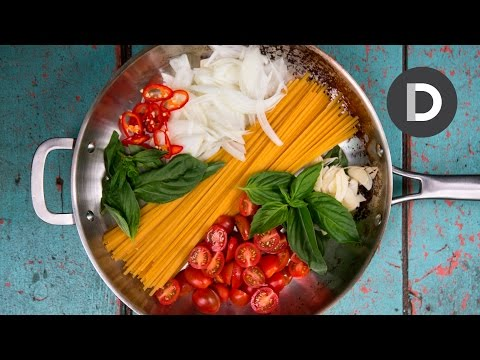

In [22]:
from IPython.display import YouTubeVideo

# Change the Youtube_ID with the link to your group's video.
YOUTUBE_ID = '0VQEJARHJ44'

YouTubeVideo(YOUTUBE_ID)

In [23]:
!rm -rf youtube.mp4
# download the youtube with the given ID
!youtube-dl -f 'bestvideo[ext=mp4]' --output "youtube.%(ext)s" https://www.youtube.com/watch?v=$YOUTUBE_ID

[youtube] 0VQEJARHJ44: Downloading webpage
[download] Destination: youtube.mp4
[download] 100% of 72.10MiB in 15:13


In [38]:
# Load the video
encoded_vid = pytorchvideo.data.encoded_video.EncodedVideo.from_path('/content/kitchen.mp4')
print('Completed loading encoded video.')

ERROR:libav.mov,mp4,m4a,3gp,3g2,mj2:moov atom not found


RuntimeError: ignored

In [37]:
# Video predictions are generated at an internal of 1 sec from 90 seconds to 100 seconds in the video.
time_stamp_range = range(90,100) # time stamps in video for which clip is sampled. 
clip_duration = 1.0 # Duration of clip used for each inference step.
gif_imgs = []

for time_stamp in time_stamp_range:    
    print("Generating predictions for time stamp: {} sec".format(time_stamp))
    
    # Generate clip around the designated time stamps
    inp_imgs = encoded_vid.get_clip(
        time_stamp - clip_duration/2.0, # start second
        time_stamp + clip_duration/2.0  # end second
    )
    inp_imgs = inp_imgs['video']
    
    # Generate people bbox predictions using Detectron2's off the self pre-trained predictor
    # We use the the middle image in each clip to generate the bounding boxes.
    inp_img = inp_imgs[:,inp_imgs.shape[1]//2,:,:]
    inp_img = inp_img.permute(1,2,0)
    
    # Predicted boxes are of the form List[(x_1, y_1, x_2, y_2)]
    predicted_boxes = get_person_bboxes(inp_img, predictor) 
    if len(predicted_boxes) == 0: 
        print("Skipping clip no frames detected at time stamp: ", time_stamp)
        continue
        
    # Preprocess clip and bounding boxes for video action recognition.
    inputs, inp_boxes, _ = ava_inference_transform(inp_imgs, predicted_boxes.numpy())
    # Prepend data sample id for each bounding box. 
    # For more details refere to the RoIAlign in Detectron2
    inp_boxes = torch.cat([torch.zeros(inp_boxes.shape[0],1), inp_boxes], dim=1)
    
    # Generate actions predictions for the bounding boxes in the clip.
    # The model here takes in the pre-processed video clip and the detected bounding boxes.
    if isinstance(inputs, list):
        inputs = [inp.unsqueeze(0).to(device) for inp in inputs]
    else:
        inputs = inputs.unsqueeze(0).to(device)
    preds = video_model(inputs, inp_boxes.to(device))

    preds= preds.to('cpu')
    # The model is trained on AVA and AVA labels are 1 indexed so, prepend 0 to convert to 0 index.
    preds = torch.cat([torch.zeros(preds.shape[0],1), preds], dim=1)
    
    # Plot predictions on the video and save for later visualization.
    inp_imgs = inp_imgs.permute(1,2,3,0)
    inp_imgs = inp_imgs/255.0
    out_img_pred = video_visualizer.draw_clip_range(inp_imgs, preds, predicted_boxes)
    gif_imgs += out_img_pred

print("Finished generating predictions.")

Generating predictions for time stamp: 90 sec


AttributeError: ignored

In [27]:
height, width = gif_imgs[0].shape[0], gif_imgs[0].shape[1]

vide_save_path = 'output_detections.mp4'
video = cv2.VideoWriter(vide_save_path,cv2.VideoWriter_fourcc(*'DIVX'), 7, (width,height))

for image in gif_imgs:
    img = (255*image).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    video.write(img)
video.release()

print('Predictions are saved to the video file: ', vide_save_path)

Predictions are saved to the video file:  output_detections.mp4
